# Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install albumentations

In [4]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 48.8 MB/s eta 0:00:00


In [5]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
from torchmetrics.classification import MulticlassJaccardIndex
from torchvision.models.segmentation import deeplabv3_resnet101
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# EDA :

## 1. Load the dataset:

In [6]:
# Paths to folders
image_dir = "/content/drive/MyDrive/data_hack /kaggle_workshop1/Data/Image"
mask_dir = "/content/drive/MyDrive/data_hack /kaggle_workshop1/Data/Mask"

# List all files
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

print(f"Number of Images: {len(image_files)}")
print(f"Number of Masks: {len(mask_files)}")

# Ensure each image has a corresponding mask
for img, mask in zip(image_files, mask_files):
    if os.path.splitext(img)[0] != os.path.splitext(mask)[0]:
        print(f"Mismatch: {img} and {mask}")


Number of Images: 290
Number of Masks: 290


## 2. Visualize Sample Pairs


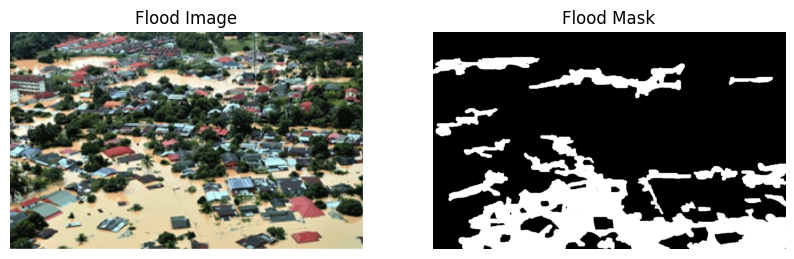

In [7]:
# Load a sample image and mask
sample_img_path = os.path.join(image_dir, image_files[0])
sample_mask_path = os.path.join(mask_dir, mask_files[0])
#print(sample_img_path)
#print(sample_mask_path)
image = cv2.imread(sample_img_path)  # Load image

# Check if image loaded successfully
if image is None:
    print(f"Error: Could not load image from {sample_img_path}. Check the file path and permissions.")
else:
    mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

    # Display them side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Flood Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Flood Mask")
    plt.axis("off")
    plt.show()

## 3. Check Image and Mask Dimensions

In [8]:
# Check dimensions of images and masks
for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
    img_path = os.path.join(image_dir, img_file)  # Create the full image path
    mask_path = os.path.join(mask_dir, mask_file) # Create the full mask path

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if image and mask loaded successfully
    if img is None:
        print(f"Error: Could not load image from {img_path}. Check the file path and permissions.")
        continue  # Skip to the next iteration if image loading failed

    if mask is None:
        print(f"Error: Could not load mask from {mask_path}. Check the file path and permissions.")
        continue # Skip to the next iteration if mask loading failed

    print(f"Image {i+1}: {img.shape}, Mask {i+1}: {mask.shape}")

    if img.shape[:2] != mask.shape:
        print(f"Mismatch in dimensions for: {img_file}")


Image 1: (551, 893, 3), Mask 1: (551, 893)
Image 2: (300, 500, 3), Mask 2: (300, 500)
Image 3: (900, 1200, 3), Mask 3: (900, 1200)
Image 4: (1367, 2100, 3), Mask 4: (1367, 2100)
Image 5: (726, 982, 3), Mask 5: (726, 982)
Image 6: (523, 929, 3), Mask 6: (523, 929)
Image 7: (676, 1200, 3), Mask 7: (676, 1200)
Image 8: (1400, 2100, 3), Mask 8: (1400, 2100)
Image 9: (418, 630, 3), Mask 9: (418, 630)
Image 10: (394, 700, 3), Mask 10: (394, 700)
Image 11: (450, 750, 3), Mask 11: (450, 750)
Image 12: (270, 480, 3), Mask 12: (270, 480)
Image 13: (575, 862, 3), Mask 13: (575, 862)
Image 14: (1400, 2100, 3), Mask 14: (1400, 2100)
Image 15: (600, 900, 3), Mask 15: (600, 900)
Image 16: (440, 604, 3), Mask 16: (440, 604)
Image 17: (354, 630, 3), Mask 17: (354, 630)
Image 18: (549, 976, 3), Mask 18: (549, 976)
Image 19: (433, 770, 3), Mask 19: (433, 770)
Image 20: (443, 760, 3), Mask 20: (443, 760)
Image 21: (402, 715, 3), Mask 21: (402, 715)
Image 22: (583, 875, 3), Mask 22: (583, 875)
Image 23: (5

## 4. Analyze Mask Content:


In [9]:
# Analyze a sample mask
unique_values = np.unique(mask)
print(f"Unique Pixel Values in Mask: {unique_values}")

# Check if masks are binary
is_binary = np.array_equal(unique_values, [0, 1])
print(f"Masks are Binary: {is_binary}")


Unique Pixel Values in Mask: [  0   1   4   5   8   9  10  15  16  18  21  24  25  28  29  30  31  32
  33  34  35  36  39  40  42  43  45  46  47  48  51  56  57  58  61  63
  64  66  71  72  73  74  76  78  79  80  85  87  88  93  95  96 100 102
 103 104 105 106 107 108 111 112 113 115 117 118 119 120 124 125 126 127
 128 129 130 135 136 137 138 139 143 144 145 146 147 148 150 151 152 153
 154 155 156 157 159 160 164 165 166 167 168 169 170 171 172 174 175 176
 178 179 180 181 182 183 184 186 187 190 191 192 195 196 197 199 200 201
 202 203 204 206 207 208 211 212 213 214 215 216 217 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255]
Masks are Binary: False


## 5. Statistical Overview:

In [10]:
mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)
# Check the unique pixel values in the mask
unique_values = np.unique(mask)

#flood region is represented by 255
flood_pixel_value = 255

# Calculate flood region percentage
flood_pixels = np.sum(mask == flood_pixel_value)
total_pixels = mask.size
flood_percentage = (flood_pixels / total_pixels) * 100

print(f"Flood Region Percentage: {flood_percentage:.2f}%")



Flood Region Percentage: 23.36%


## 6. Explore Metadata:


In [11]:
# Load metadata
metadata_path = "/content/drive/MyDrive/data_hack /kaggle_workshop1/Data/metadata.csv"
metadata = pd.read_csv(metadata_path)

print(metadata.head())  # Display first few rows
print(metadata.info())  # Check for missing data or anomalies


   Image   Mask
0  0.jpg  0.png
1  1.jpg  1.png
2  2.jpg  2.png
3  3.jpg  3.png
4  4.jpg  4.png
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   290 non-null    object
 1   Mask    290 non-null    object
dtypes: object(2)
memory usage: 4.7+ KB
None


## 7. Insights:
 - we have 5 images that Mismatch in dimensions.
 - in image 1.jpg we have 23.37% flood region percentage!

# pre-processing:

## 1. Normalize and Prepare the Images:

In [12]:
# Define image transformations
image_transforms = transforms.Compose([
    transforms.ToPILImage(),              # Convert to PIL image
    transforms.Resize((256, 256)),        # Resize images to 256x256
    transforms.ToTensor(),                # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to match pretrained model expectations
])

## 2. Process the Masks:

In [13]:
def process_mask(mask_path):
    # Read mask as grayscale
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        raise ValueError(f"Failed to read mask from {mask_path}. Check the file path.")

    # Resize to 256x256
    resized_mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

    # Ensure the mask is in the correct format for multi-class segmentation
    return resized_mask.astype('int64')  # Keep as integers for class labels



## 3. Update the Dataset Class:

In [14]:
def get_mask_path(image_file, mask_dir):
      # Assumes the mask has the same name as the image but with .png extension
      mask_file = os.path.splitext(image_file)[0] + ".png"
      return os.path.join(mask_dir, mask_file)

In [15]:
class FloodDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, file_list, transform=None, augmentations=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.transform = transform
        self.augmentations = augmentations

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
      image_file = self.file_list[idx]
      image_path = os.path.join(self.image_dir, image_file)
      mask_path = get_mask_path(image_file, self.mask_dir)

      # Load image and mask
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

      if image is None or mask is None:
          raise ValueError(f"Image or mask not found for index {idx}. Check paths.")

      # Ensure image and mask are numpy arrays
      image = np.array(image, dtype=np.uint8)
      mask = np.array(mask, dtype=np.uint8)

      # Resize image and mask
      image = cv2.resize(image, (256, 256))
      mask = cv2.resize(mask, (256, 256))

      # Apply augmentations if provided
      if self.augmentations:
          augmented = self.augmentations(image=image, mask=mask)
          image = augmented['image']
          mask = augmented['mask']

      # Apply transformations if provided
      if self.transform:
          transformed = self.transform(image=image, mask=mask)
          image = transformed['image']
          mask = transformed['mask']

      return image, mask



## 4. Test the Data Processing:

Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])


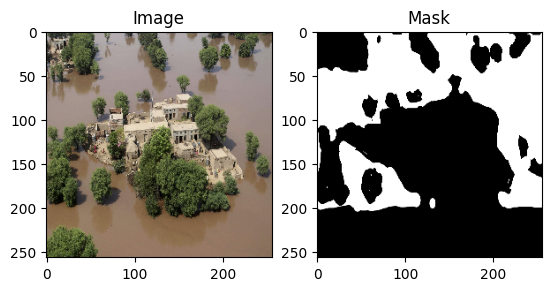

In [16]:
# Example file list (you would use your actual split files here)
file_list = os.listdir(image_dir)

# Define augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

# Create dataset
dataset = FloodDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    file_list=file_list,
    transform=None,  # Only use one of augmentations or transform at a time
    augmentations=augmentations  # Correctly configured augmentations
)

# Test data loading
sample_image, sample_mask = dataset[1]

print(f"Image shape: {sample_image.shape}")
print(f"Mask shape: {sample_mask.shape}")


plt.subplot(1, 2, 1)
plt.imshow(sample_image.permute(1, 2, 0))  # Convert tensor to image format
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title("Mask")

plt.show()


# Load Pre-Trained DeepLabV3

In [17]:
import torchvision.models.segmentation as segmentation

# Load pre-trained DeepLabV3+ model
model = segmentation.deeplabv3_resnet101(pretrained=True)

# Modify the model for your task (2 classes: flood and background)
num_classes = 2  # Background + Flood
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function (CrossEntropyLoss works well for multi-class segmentation)
criterion = torch.nn.CrossEntropyLoss()

# Define optimizer (Adam is commonly used)
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # You can adjust the learning rate as needed

print(f"model has been loaded successfully! {model}")


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 178MB/s]


model has been loaded successfully! DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(in

# Train the Model:

## 1. split the data:

In [18]:
# Paths to folders
image_dir = "/content/drive/MyDrive/data_hack /kaggle_workshop1/Data/Image"
mask_dir = "/content/drive/MyDrive/data_hack /kaggle_workshop1/Data/Mask"

# Get a list of all image file names
image_files = os.listdir(image_dir)

# Split into train (70%), validation (15%), and test (15%)
train_files, val_test_files = train_test_split(image_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(val_test_files, test_size=0.5, random_state=42)

print(f"Training: {len(train_files)}, Validation: {len(val_files)}, Test: {len(test_files)}")


Training: 203, Validation: 43, Test: 44


## 2. Update the class:

In [19]:
class FloodDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, file_list, augmentations=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.augmentations = augmentations

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image_file = self.file_list[idx]
        image_path = os.path.join(self.image_dir, image_file)
        mask_path = get_mask_path(image_file, self.mask_dir)

        # Load image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
          raise ValueError(f"Failed to load image: {image_path}")
        if mask is None:
         raise ValueError(f"Failed to load mask: {mask_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Resize to consistent dimensions
        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        # Apply augmentations (if any)
        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Convert mask to 2 classes (0 for background, 1 for flood)
        mask = np.where(mask > 127, 1, 0).astype(np.float32)  # Threshold the mask

        # Convert image and mask to PyTorch tensors
        #image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
        mask = torch.tensor(mask, dtype=torch.long)  # Use long type for segmentation mask

        return image, mask


## 3. Store the data splits:

In [20]:
# Save the splits
data_splits = {
    "train": train_files,
    "val": val_files,
    "test": test_files,
}

# Define augmentations for training
augmentations = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),  # Random horizontal flip
    A.RandomRotate90(p=0.5),  # Random 90-degree rotation
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize pixel values
    ToTensorV2()  # Converts to PyTorch tensor: Image [C, H, W] and Mask [1, H, W]
])


# Validation and test transformations (only normalization)
image_transforms = A.Compose([
    A.Resize(256, 256),  # Ensure images are resized for all sets
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_dataset = FloodDataset(
    image_dir="/content/drive/MyDrive/data_hack /kaggle_workshop1/Data/Image",
    mask_dir="/content/drive/MyDrive/data_hack /kaggle_workshop1/Data/Mask",
    file_list=data_splits["train"],
    augmentations=augmentations
)

val_dataset = FloodDataset(
    image_dir="/content/drive/MyDrive/data_hack /kaggle_workshop1/Data/Image",
    mask_dir="/content/drive/MyDrive/data_hack /kaggle_workshop1/Data/Mask",
    file_list=data_splits["val"],
    augmentations=image_transforms  # Normalization
)

test_dataset = FloodDataset(
    image_dir="/content/drive/MyDrive/data_hack /kaggle_workshop1/Data/Image",
    mask_dir="/content/drive/MyDrive/data_hack /kaggle_workshop1/Data/Mask",
    file_list=data_splits["test"],
    augmentations=image_transforms  # Normalization
)

## 4.Create DataLoaders:

In [21]:
def custom_collate(batch):
    images = [item[0] for item in batch]
    masks = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    masks = torch.stack(masks, dim=0)
    return images, masks

# Define batch size
batch_size = 4

# Creat the DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=custom_collate)


print(f"DataLoaders created: Train={len(train_loader)}, Validation={len(val_loader)}, Test={len(test_loader)}")


DataLoaders created: Train=51, Validation=11, Test=11


## 5.Train the Model:

In [22]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)  # Move images to GPU/CPU
        masks = masks.to(device).long()  # Convert masks to long type
        masks = masks.squeeze(1)  # Ensure masks are in the correct shape for multi-class segmentation

        # Forward pass
        outputs = model(images)  # Get outputs from the model
        main_output = outputs['out']  # Main segmentation logits
        aux_output = outputs['aux']   # Auxiliary segmentation logits

        # Ensure outputs are in the correct shape for multi-class segmentation
        main_output = main_output.squeeze(1)  # Remove the channel dimension
        aux_output = aux_output.squeeze(1)  # Remove the channel dimension


        # Calculate main loss and auxiliary loss
        main_loss = criterion(main_output, masks)
        aux_loss = criterion(aux_output, masks)

        # Combine the losses with weighting
        loss = main_loss + 0.4 * aux_loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device).long()

            # Ensure masks are in the correct shape for multi-class segmentation
            masks = masks.squeeze(1)  # Remove the channel dimension

            outputs = model(images)
            main_output = outputs['out']
            aux_output = outputs['aux']

            # Ensure outputs are in the correct shape for multi-class segmentation
            main_output = main_output.squeeze(1)  # Remove the channel dimension
            aux_output = aux_output.squeeze(1)  # Remove the channel dimension

            # Validation loss
            main_loss = criterion(main_output, masks)
            aux_loss = criterion(aux_output, masks)
            loss = main_loss + 0.4 * aux_loss
            val_loss += loss.item()

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1/15, Train Loss: 0.9442, Val Loss: 0.5439
Epoch 2/15, Train Loss: 0.5995, Val Loss: 0.4665
Epoch 3/15, Train Loss: 0.5364, Val Loss: 0.4247
Epoch 4/15, Train Loss: 0.4720, Val Loss: 0.3623
Epoch 5/15, Train Loss: 0.4198, Val Loss: 0.3643
Epoch 6/15, Train Loss: 0.4217, Val Loss: 0.3625
Epoch 7/15, Train Loss: 0.3721, Val Loss: 0.3384
Epoch 8/15, Train Loss: 0.3421, Val Loss: 0.3210
Epoch 9/15, Train Loss: 0.3438, Val Loss: 0.3254
Epoch 10/15, Train Loss: 0.3352, Val Loss: 0.3363
Epoch 11/15, Train Loss: 0.3416, Val Loss: 0.3237
Epoch 12/15, Train Loss: 0.3122, Val Loss: 0.3679
Epoch 13/15, Train Loss: 0.2963, Val Loss: 0.3054
Epoch 14/15, Train Loss: 0.2873, Val Loss: 0.3314
Epoch 15/15, Train Loss: 0.3113, Val Loss: 0.3779


# Evaluate The Model:

## 1. Test the Model:

In [23]:
# Metric initialization (replace `256` with the actual number of classes)
iou_metric = MulticlassJaccardIndex(num_classes=256, ignore_index=0).to(device)  # Optional to ignore background

# Store metrics
test_loss = 0.0
iou_score = 0.0

# No gradient calculation during testing
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device).long()
        masks = masks.squeeze(1)  # Remove the channel dimension

        # Forward pass
        outputs = model(images)['out']  # Use main output for evaluation
        predictions = outputs.argmax(dim=1)  # Get class predictions

        # Compute loss
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        # Compute IoU
        iou_score += iou_metric(predictions, masks).item()

# Average metrics
test_loss /= len(test_loader)
iou_score /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Mean IoU Score: {iou_score:.4f}")


Test Loss: 0.2340
Mean IoU Score: 0.9012


## 2.Visualize Predictions

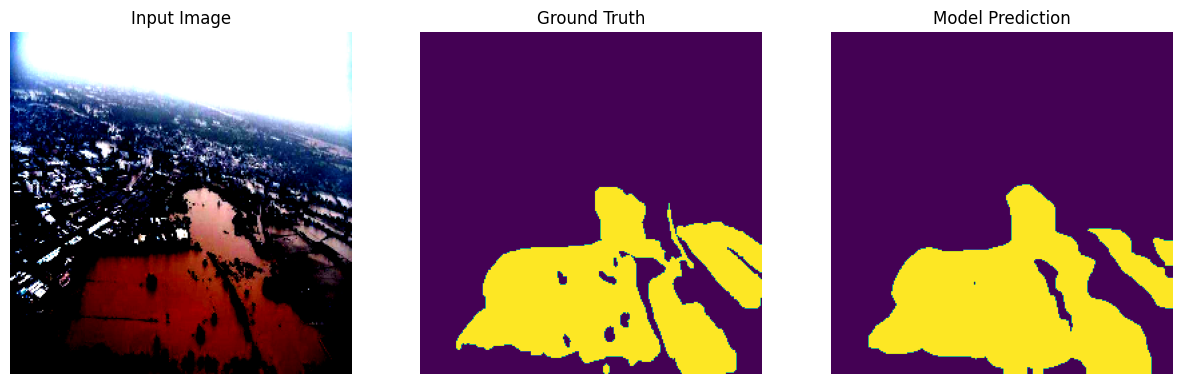

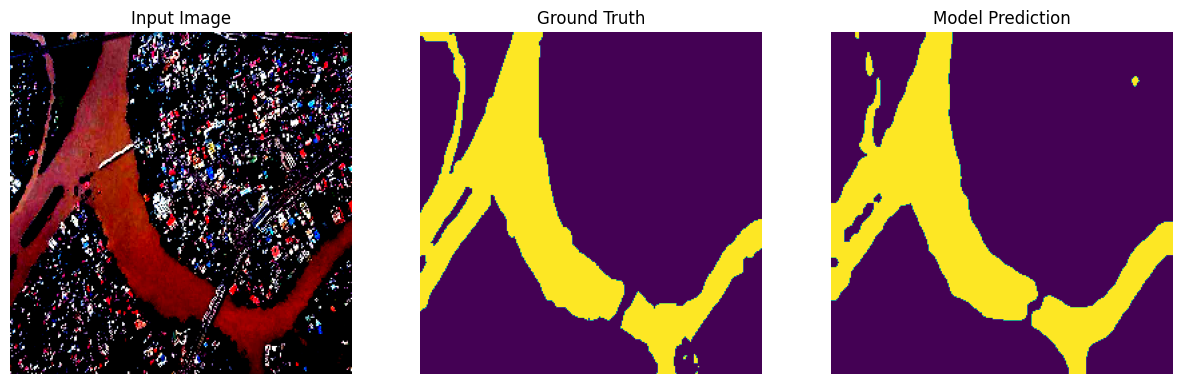

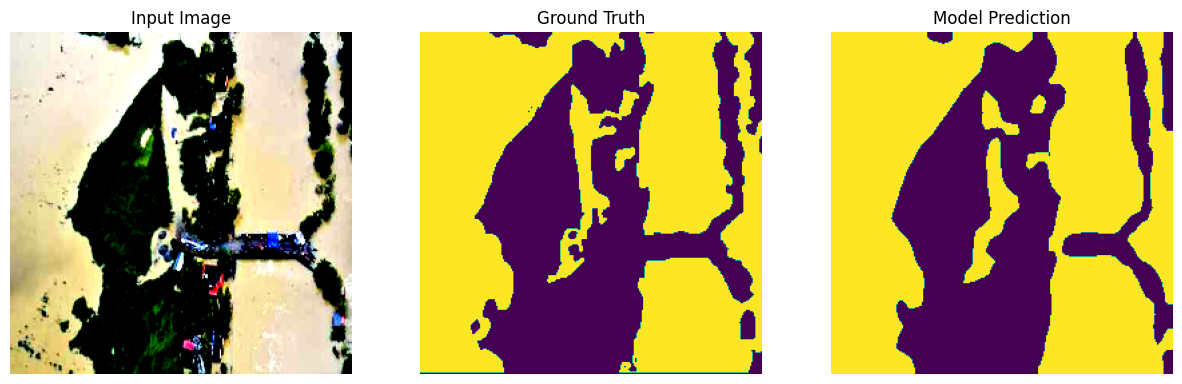

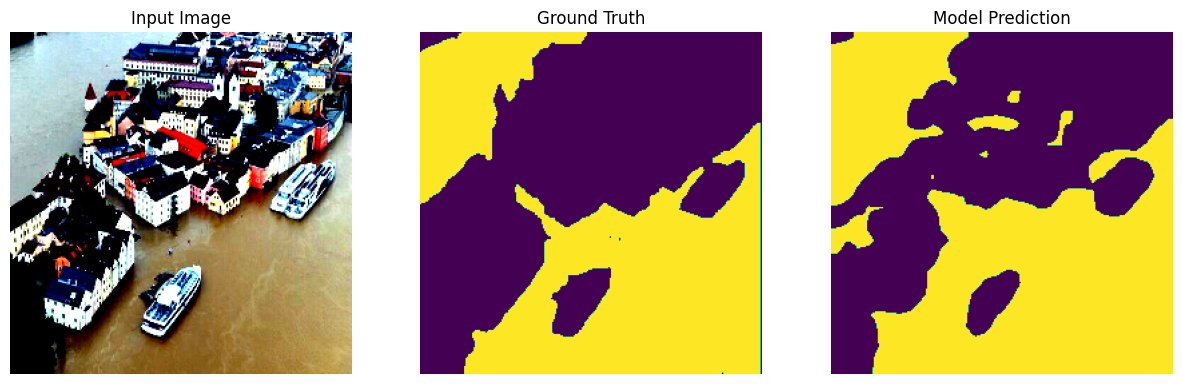

In [33]:
# Function to visualize a single image, ground truth, and prediction
def visualize(image, mask, prediction):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(mask.cpu().numpy(), cmap='viridis')
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    axes[2].imshow(prediction.cpu().numpy(), cmap='viridis')
    axes[2].set_title("Model Prediction")
    axes[2].axis("off")

    plt.show()

# Test a single batch
images, masks = next(iter(test_loader))
images = images.squeeze(1)
images = images.to(device)
masks = masks.squeeze(1)  # Remove the channel dimension
masks = masks.to(device).long()

with torch.no_grad():
    outputs = model(images)['out']
    predictions = outputs.argmax(dim=1)

# Visualize the first image in the batch
for i in range(len(images)):
  visualize(images[i], masks[i], predictions[i])



##3. Save the Model:

In [35]:
torch.save(model.state_dict(), "/content/drive/MyDrive/data_hack /kaggle_workshop1/segmentation_model.pth")